In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler

In [2]:
def moving_average(a, n=10): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret/=n
    # Masking
    ret[:n-1]=ret[n-1]
    ret=ret.reshape(-1,1)
    return ret

def read_train_patients(input_len = 8, output_len = 6):
    x_train=[]
    y_train=[]
    #y_train_f=[]
    for i in range(1, 15):
        #y_noised=[]
        
        df=pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
        dataset=df.values
        dataset = moving_average(dataset)

        scaler = MinMaxScaler(feature_range=(0, 1)) 
        scaled_data = scaler.fit_transform(dataset)
        train_data = scaled_data
        #train_data = dataset
        
        for i in range(input_len,len(train_data)-output_len):
            x_train.append(train_data[i-input_len:i,0])
            y_train.append(train_data[i+output_len-1,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape 
    #x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    return scaler, x_train, y_train

In [3]:
#random forest
def train_model_RFR(x_train, y_train, n_estimators=1000):
    X_val = x_train[11000:]
    Y_val = y_train[11000:]
    X_train = x_train[:11000]
    Y_train = y_train[:11000]

    #random_forest = RandomForestRegressor(n_estimators=n_estimators,random_state=100,oob_score=True)
    #random_forest.fit(X_train, Y_train)
    
    random_forest = RandomForestRegressor()
        
    #find best hyperparams
    param_grid = {
    'n_estimators': [235, 500, 530, 525, 600],
    'max_depth': [8, 10, 12],
    'min_samples_split': [1, 2],
    'max_features': ['auto', 'sqrt'],
    }
    
    grid_cv = GridSearchCV(random_forest, param_grid=param_grid, cv=2, n_jobs=-1)
    gs_results = grid_cv.fit(X_train,Y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    random_forest = RandomForestRegressor(n_estimators=gs_results.best_params_['n_estimators'],random_state=0,oob_score=False)
    random_forest.fit(X_train, Y_train)
    
    """curve = pd.DataFrame(rmse_val) #elbow curve 
    print(curve)
    plt.figure(figsize=(24,16))
    plt.title('RMSE according to the Num of Neighbors(K)',fontsize=40)
    plt.plot(curve, linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel('value of K',fontsize=28)
    plt.ylabel('RMSE',fontsize=28)"""
    
    #validation
    prediction = random_forest.predict(X_val)
    r_squared = random_forest.score(X_val, Y_val)
    error = np.sqrt(mean_squared_error(Y_val,prediction))
    print('RMSE: ',error )
    
    return random_forest


In [4]:
scaler, x_train, y_train = read_train_patients()

In [5]:
random_forest = train_model_RFR(x_train, y_train) 

0.917009307855577
RandomForestRegressor(max_depth=12, n_estimators=530)
{'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 530}
RMSE:  0.05226672027526507


In [6]:
def show_plots(i, continuous_ytest, continuous_predictions):
    plt.figure(figsize=(24,16))
    plt.title('Blood Glucose Prediction Model Result_patient_{}'.format(i),fontsize=40)
    plt.plot(continuous_ytest, color = 'b', linewidth=3)
    plt.plot(continuous_predictions, color = 'r', ls="--", linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.ylim(40, 260)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.xlabel('Timestamp',fontsize=28)
    plt.ylabel('BG(CGM) (mg/dL)',fontsize=28)
    plt.legend(['Real','Predictions'], loc='upper right',fontsize=32)
    plt.show()

In [7]:
def test_model(model, i, input_len=8, output_len=6):
    df = pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
    dataset=df.values
    
    dataset = moving_average(dataset)
    
    # Scalling data from 0 - 1 to input in the neural network
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset)
    
    x_test =[]
    y_test =[]
    
    continuous_ytest=[]
    i= input_len
    
    for i in range(input_len,len(dataset)-output_len):
        x_test.append(scaled_data[i-input_len:i,0])
        y_test.append(dataset[i+output_len-1,0])
        continuous_ytest.append(dataset[i+output_len-1,0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    #y_test = np.reshape(y_test,(-1,1))
    #print("x_test: ", x_test)
    #x_test= np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    predictions = model.predict(x_test)
    predictions = np.reshape(predictions,(1,-1))
    predictions = scaler.inverse_transform(predictions)
    print(predictions)
    print(y_test)
    #print("predictions: ", predictions)
    
    continuous_predictions = predictions[0]
    for i in range(1, len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions, predictions[i]])
    
    #print(predictions)
    #print(y_test)
    
    
    rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
    mape=np.mean(np.abs((predictions-y_test)/y_test)*100)
    #print("prediction:", np.shape(pred))
    #print("y_test:",np.shape(y_test))
    #print(len(continuous_ytest))
    #print("continuouse_ytest: ", continuous_ytest)
    #print("continuous_predictions: ", continuous_predictions)
    return rmse, mape, continuous_ytest, continuous_predictions

[[107.83346477 107.83346477 107.83346477  99.96034558  99.04167821
  101.76398406 106.23169697 108.52400934 113.43958446 113.68050932
  109.3101522  111.20862441 111.10473383 113.93468838 115.00866999
  112.80899901 111.49732708 111.74236492 111.18405944 110.73381806
  109.4701459  107.79244389 107.12958499 107.93479083 104.65538085
  104.46456132 105.43275603 106.81639664 111.32508019 121.56401215
  122.54954166 131.02537152 135.40531167 139.11410072 141.55969461
  143.35108123 142.52238963 139.80559524 133.81211286 130.9222646
  127.16981568 128.10437614 129.70329656 128.39425856 126.70203989
  124.39238456 124.38836275 124.86261167 125.10189015 125.41285181
  124.08911458 121.0482258  118.34721036 114.61268379 110.49839206
  109.42042071 109.43401312 111.18374187 112.80040718 106.33636344
  103.67860178 100.86403801  98.34628862  95.38631757  94.76305056
   99.02839022 102.5087326  108.03303378 110.51350411 111.39409927
  113.55742267 116.44609871 115.88902692 116.70568034 118.21715

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


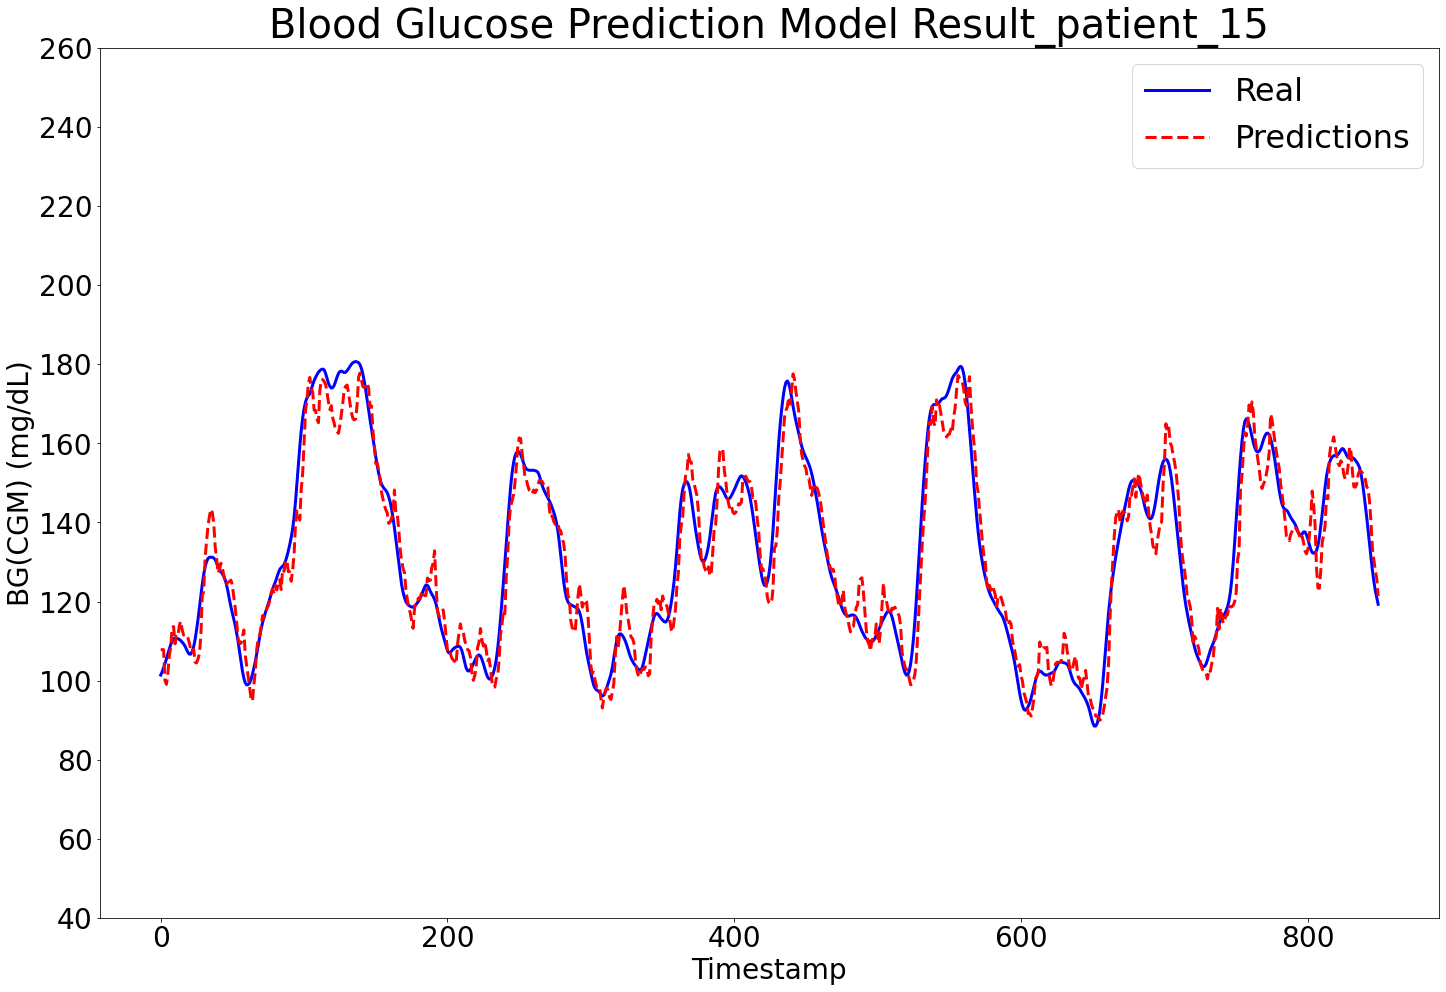

0.9787373051431593
0.9837960871680086
Time_delay(min):  10
Root-Mean-Squared Deviation 6.107736750516977
Mean-Absolute-Percentage-Error 3.6712252021961747
[[126.01805551 126.01805551 126.01805551 127.5589655  126.06266737
  126.65697433 125.73516638 123.88698247 119.21045553 117.19956366
  109.42060362 107.46783946 106.14366134 105.37757697 106.20333667
  103.19216232 104.06187288 104.54875428 109.59244732 113.19379614
  120.17922477 120.76636063 123.33906477 127.21494638 131.69616664
  133.47894013 132.61958004 128.83944234 123.20047591 127.41417615
  132.7508424  136.19604845 134.11120234 142.12309673 134.10972322
  139.65051368 136.38510461 132.48795845 130.73935967 129.52754097
  127.10842791 124.88125745 124.42021006 122.19979231 108.23327754
  107.02278683 107.63704118 108.76427485 113.24396051 112.53876324
  115.46901491 120.0020465  124.6773079  124.50721244 125.39881035
  124.09837898 124.44179079 124.97620311 123.26790263 120.53827725
  121.89514704 122.77132493 125.29556311 

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


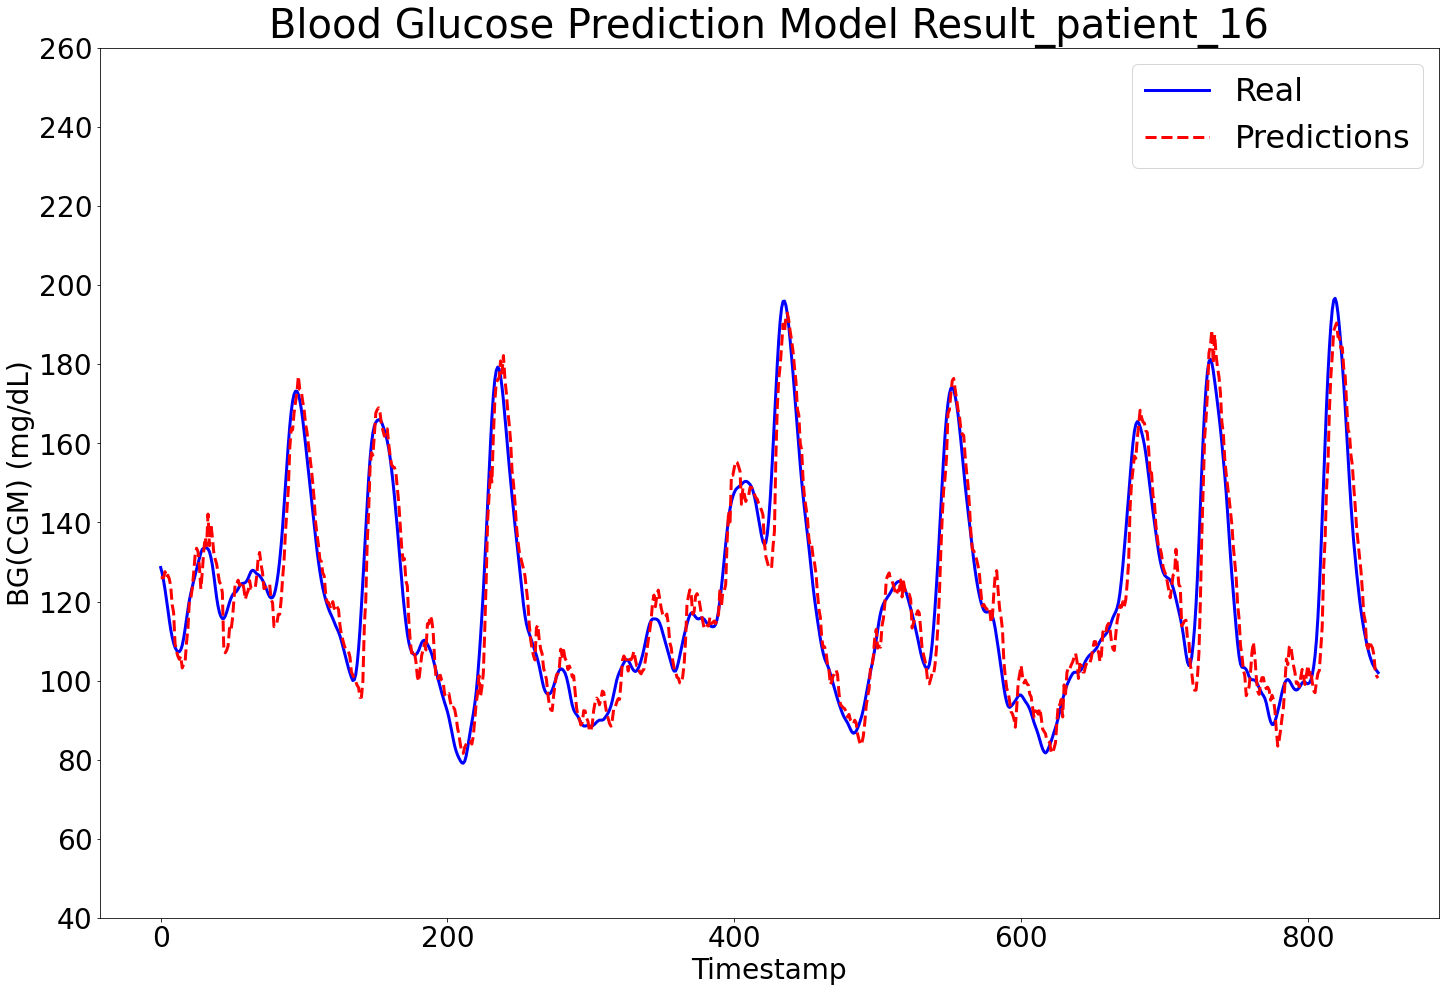

0.9819938541608098
0.9887160049102482
Time_delay(min):  10
Root-Mean-Squared Deviation 6.9314022238969155
Mean-Absolute-Percentage-Error 4.2918971631067135
[[113.24291131 113.24291131 113.24291131 113.21523269 114.15484329
  114.6801744  109.74788817 106.86632449 107.36540263 106.68887186
  108.07438233 107.53569213 105.3718437  107.433726   106.39905412
  109.09925896 109.33835001 110.72821145 111.36954553 112.24827322
  113.22351466 111.17716086 114.47228231 112.742009   110.5641753
  110.99487311 113.49693155 114.44867572 114.6829779  115.08095146
  115.98364023 114.47991064 110.71226593 108.58316654 107.47110095
  107.42799771 105.42253596 105.99164771 106.51459038 106.04472565
  104.73868946 104.83052831 104.63697546 108.70616196 105.79951885
  104.1303304  104.65103656 105.29771952 105.72292975 105.25813677
  101.50415188  99.25898115  99.73605336 101.19243575 103.6143916
  106.47466287 110.47150665 112.59111061 113.49787408 121.20709767
  125.80823224 130.51901701 128.92701722 1

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


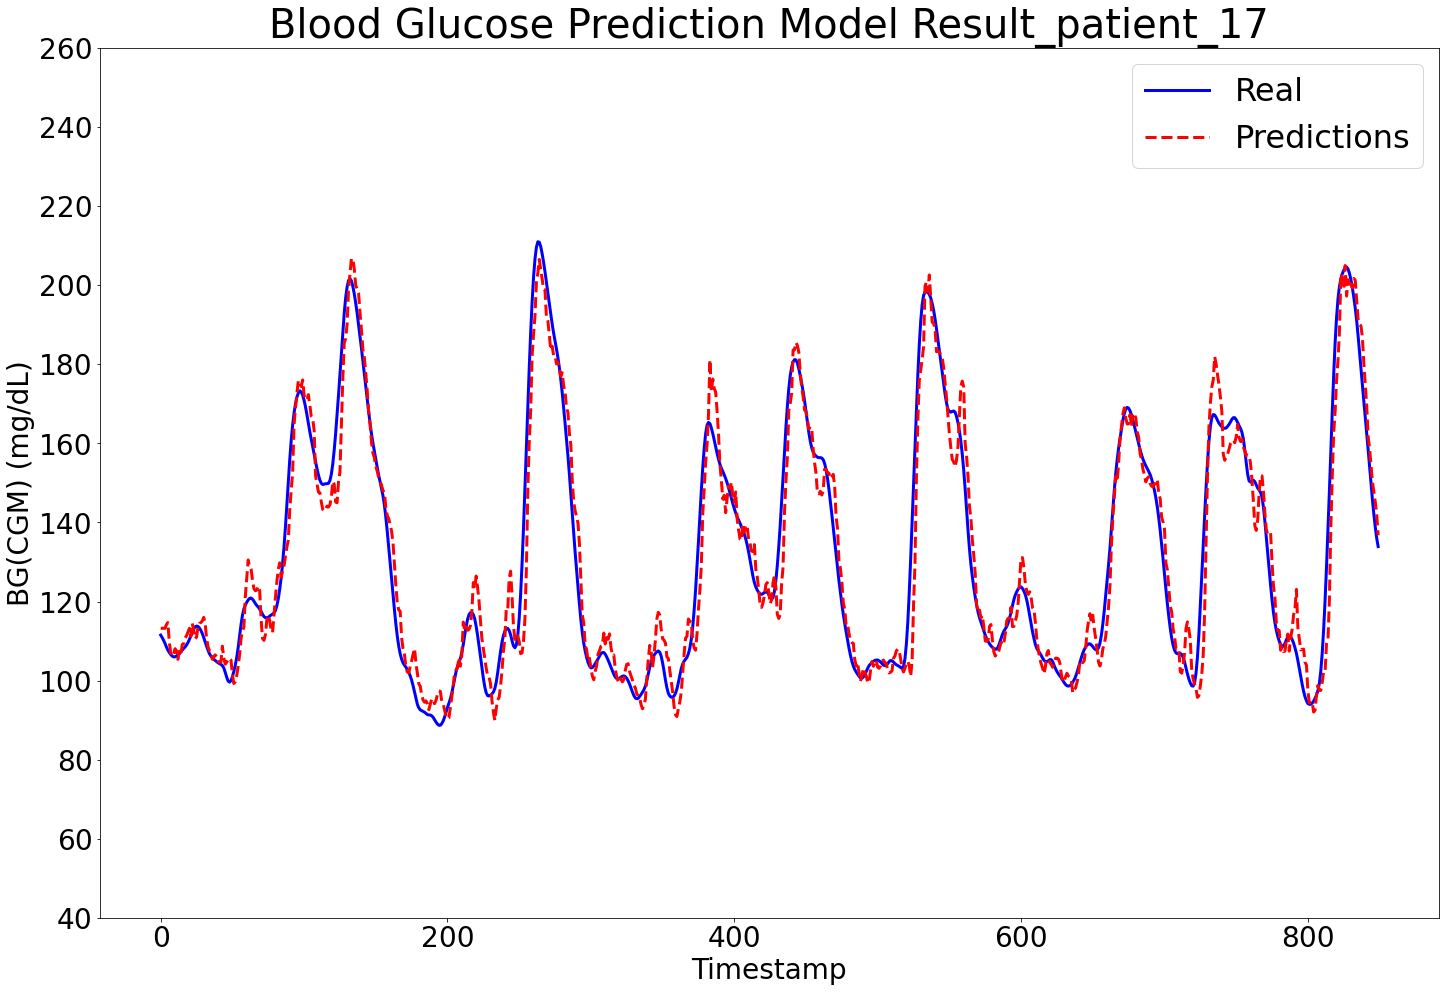

0.9826262562127858
0.987753125197954
Time_delay(min):  10
Root-Mean-Squared Deviation 7.6468809011650585
Mean-Absolute-Percentage-Error 4.1634807707298105
[[139.11441837 139.11441837 139.11441837 139.11441837 138.48972378
  136.39364109 134.97052334 134.11168322 133.5036935  132.64939222
  129.73704407 129.43553601 128.00819571 128.24470531 125.90582574
  120.39113955 118.80367484 114.71082938 114.23401972 113.98363433
  115.08718212 115.37454526 114.88790323 116.04622238 122.20900894
  123.34988746 138.12580017 135.14111592 137.13678313 129.63555764
  126.48463773 123.71914085 121.84798114 122.12139542 120.1066669
  116.31302535 111.74301056 110.98089547 113.06011588 118.31355518
  121.10433741 123.01023106 123.96983941 115.63042678 111.25910363
  110.3102632  113.1812861  114.29675993 114.30875814 113.5858062
  112.01019965 109.90101984 108.63982076 107.86986098 108.87616375
  109.71701034 110.46919638 110.60702247 110.79247903 114.09700531
  116.74787054 119.17488851 122.6307215  12

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


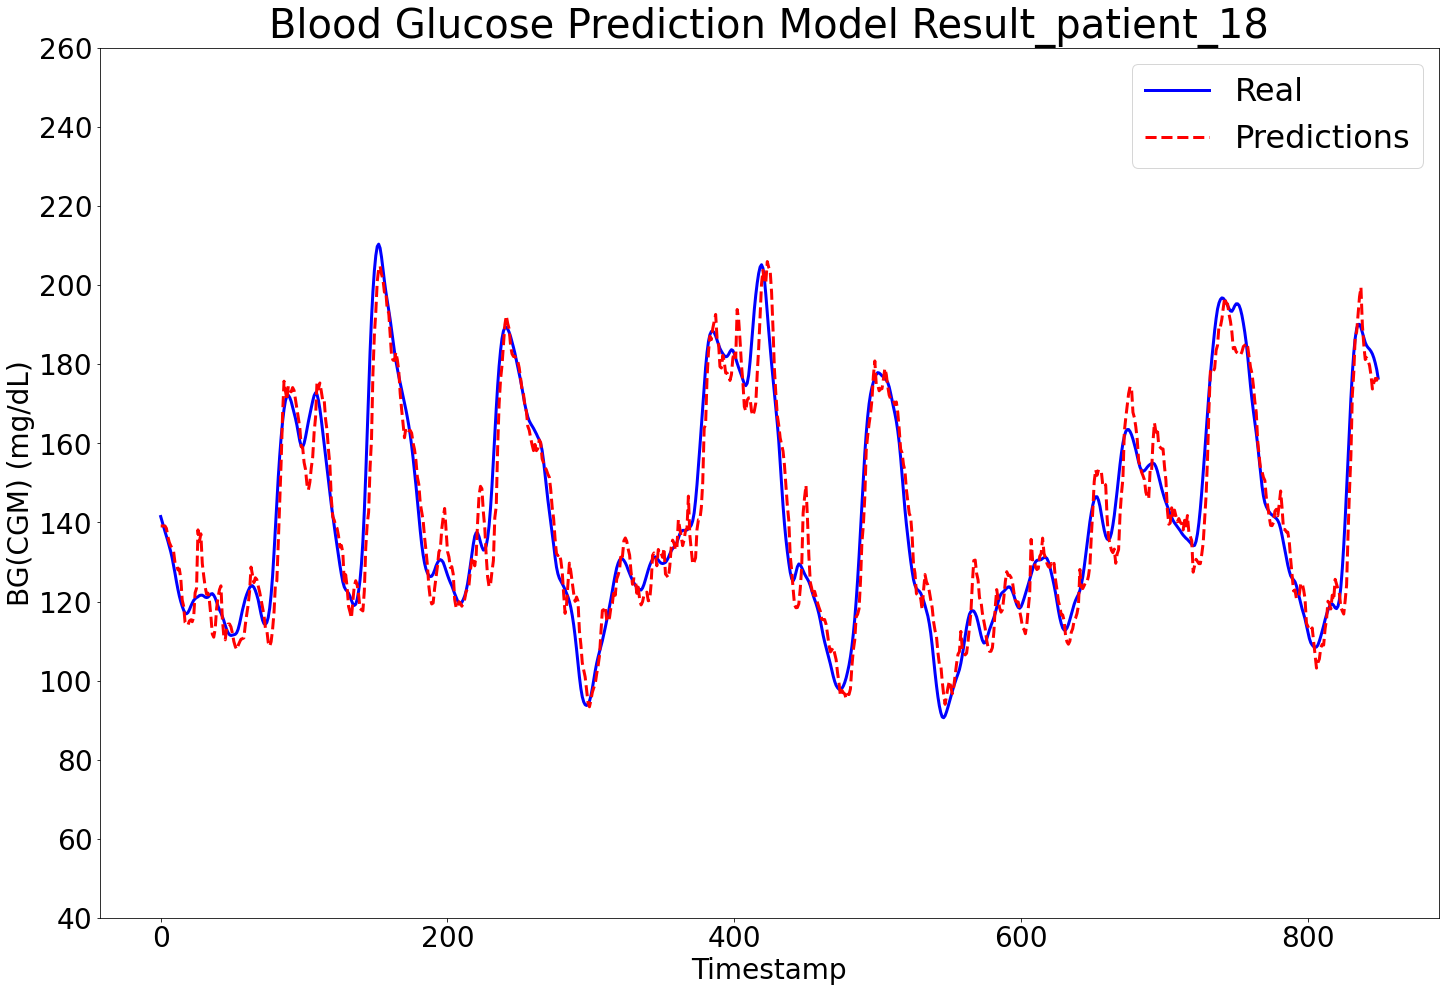

0.9760470375239724
0.9823572159958817
Time_delay(min):  10
Root-Mean-Squared Deviation 7.5034059632714705
Mean-Absolute-Percentage-Error 3.9801684707542475
[[109.70026811 109.70026811 109.70026811 111.37549364 111.61321298
  110.50827204 109.25766253 107.97566559 104.67441161 104.04608964
  104.61649327 105.4411746  103.09227258 100.82999859 102.18656012
  103.26742578 103.8509614  104.63548385 106.30761501 111.9096395
  114.73087559 114.33267054 116.60456713 124.46725879 122.71060678
  117.58771048 116.86177473 112.43548399 106.99084074 107.48650557
  110.6829704  112.72898383 112.90875304 111.59699826 112.45534857
  112.57219539 114.62903567 119.10993998 121.24783981 124.45678253
  124.26235909 129.54883469 129.85029501 137.19490044 144.41663545
  140.77747847 141.54616895 141.31572002 137.26362479 135.16006169
  134.55407354 134.01845316 131.74742859 128.38558927 130.77129596
  134.06271727 134.83543963 136.31030853 135.23062975 131.31014618
  129.17648489 128.04522166 127.96141406 

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


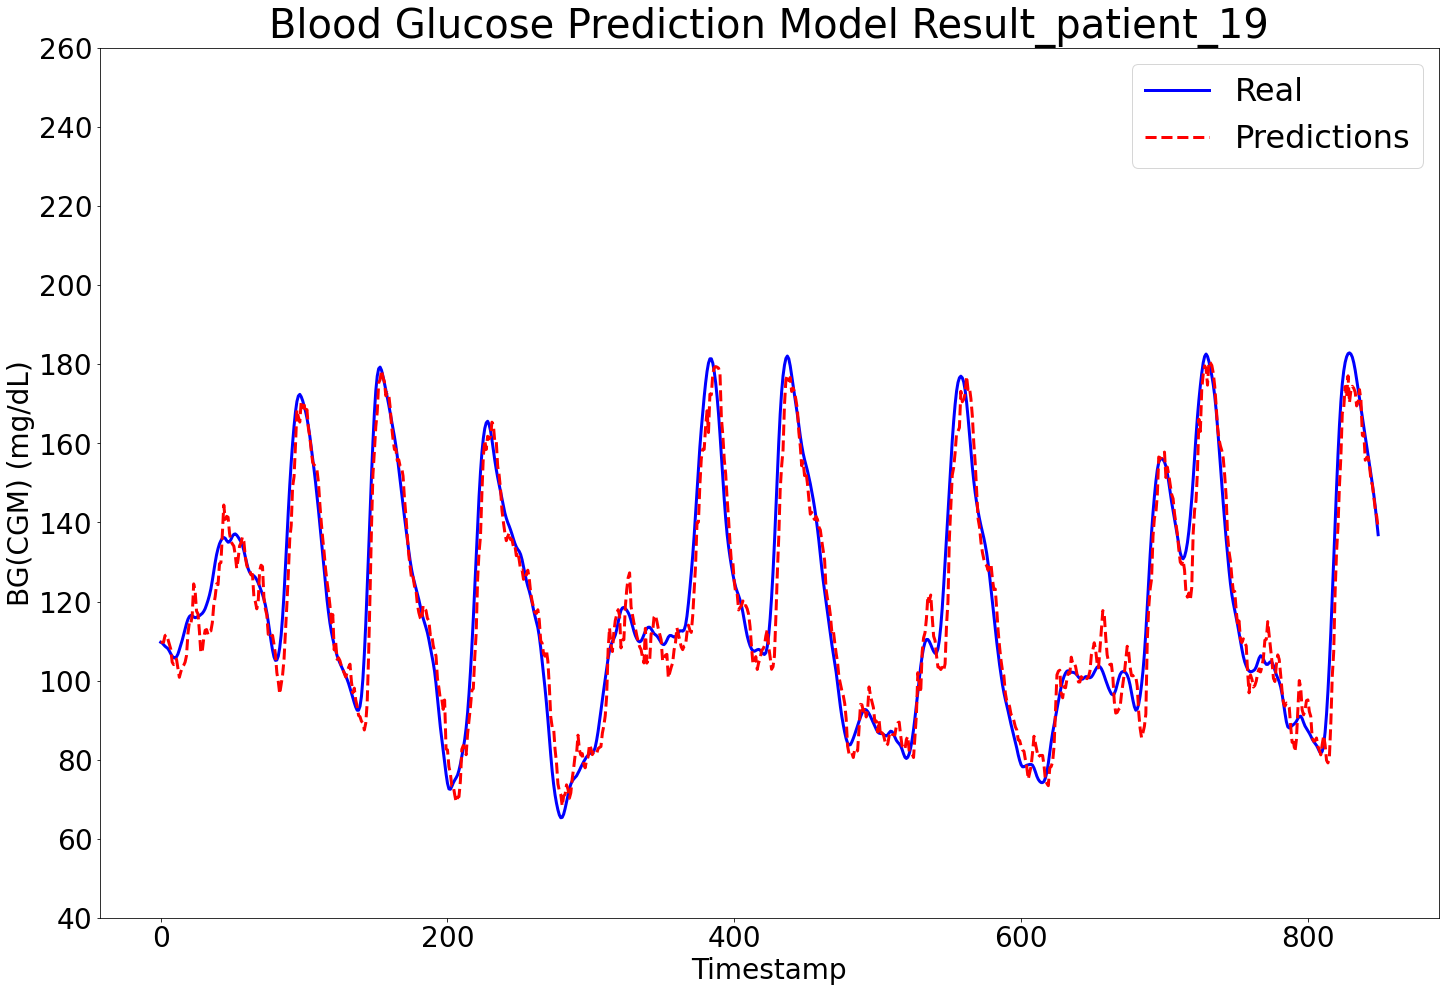

0.9839012205952101
0.9890568119173614
Time_delay(min):  10
Root-Mean-Squared Deviation 7.304047279149251
Mean-Absolute-Percentage-Error 4.569762423150634
[[121.79554615 121.79554615 121.79554615 118.34827196 117.56652081
  118.35876369 119.71390637 121.24343922 126.82505578 127.36790762
  128.80185776 129.74610661 127.84439989 130.2457051  126.17999677
  120.42255647 115.45972856 109.353869   105.41916562 104.05115962
  103.87073059 100.66091236  99.7441551   98.41037608  98.12977148
   99.59318988 102.09641534 104.21311213 104.87233515 105.9671652
  111.37882919 111.0395899  114.55674001 112.91790254 120.33822299
  114.36145322 123.27459648 123.63322093 123.33694846 128.38746798
  130.2957269  133.3702926  127.36247748 130.84941729 127.61226295
  125.88993898 123.83307752 120.71762136 117.47837179 115.28027459
  114.21863822 112.56553564 107.41043179 106.86912403 103.0445987
   98.86107448  97.54774736  99.97598591 100.21368865 102.83418376
  102.67557775 106.5356786  111.12651261 114

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


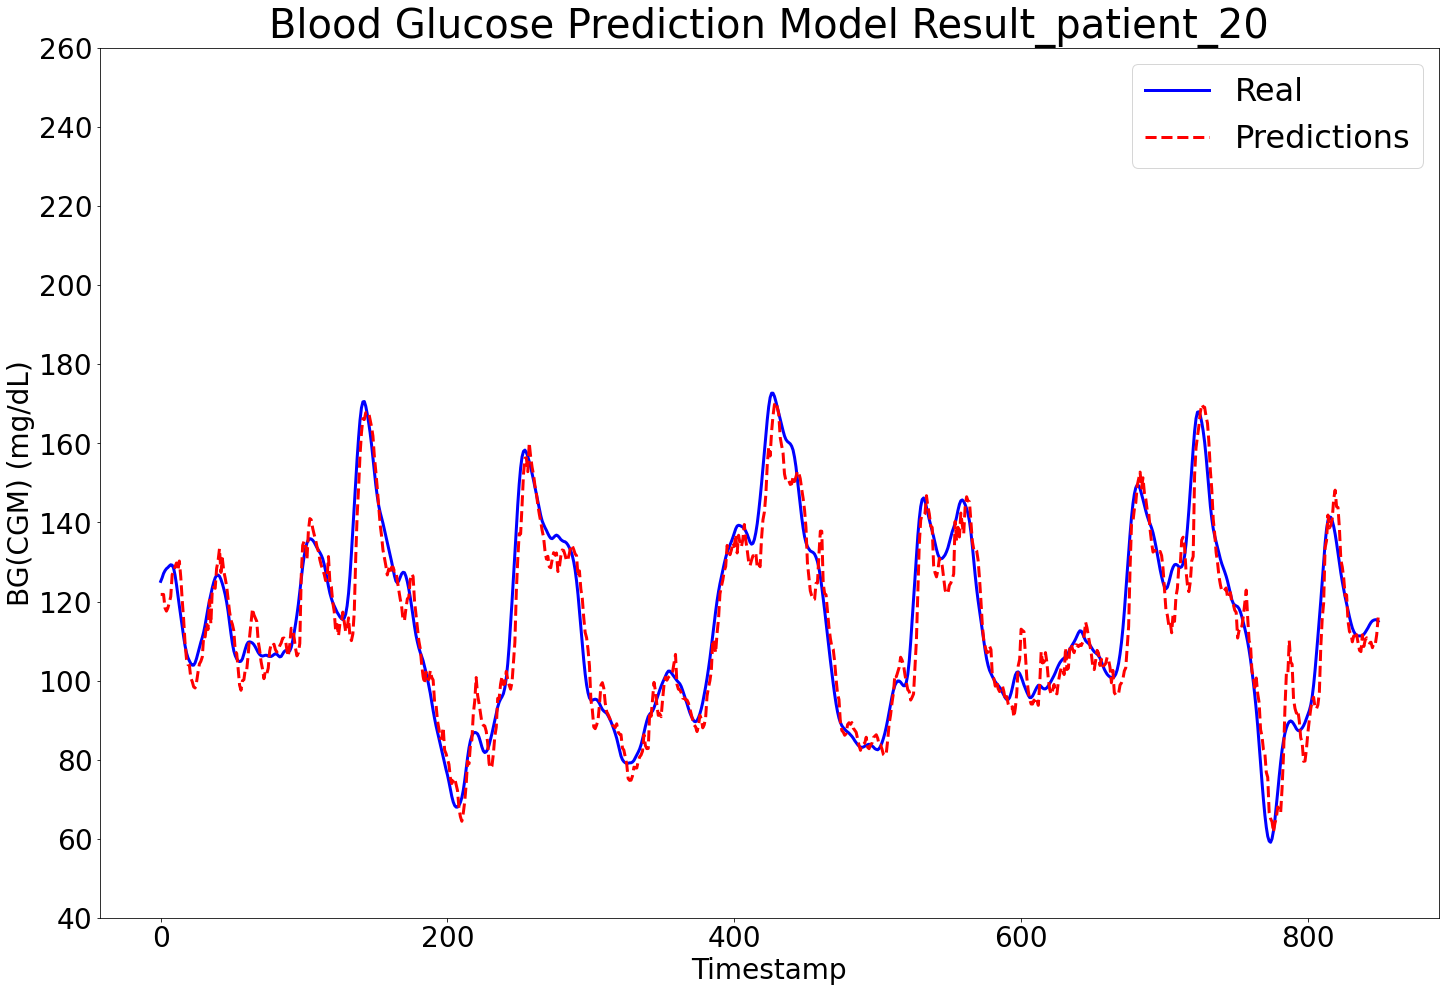

0.9741550138717656
0.9802264749809242
Time_delay(min):  10
Root-Mean-Squared Deviation 6.725640187460171
Mean-Absolute-Percentage-Error 4.4290599305455665


In [8]:
def get_time_gain(continuous_ytest, continuous_predictions):
    corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6:-6])[0,1]
    max_corr = corr
    #j=1
    max_trans = 0
    for j in range(1, 6):
        trans_corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6+j:-6+j])[0,1] 
        if max_corr < trans_corr:
            max_corr = trans_corr
            print(max_corr)
            max_trans = j
    return max_trans
    

for i in range(15,21):
    rmse, mape, continuous_ytest, continuous_predictions = test_model(random_forest, i)
    show_plots(i, continuous_ytest, continuous_predictions)
    time_gain = get_time_gain(continuous_ytest, continuous_predictions)
    print("Time_delay(min): ", time_gain*5)
    print("Root-Mean-Squared Deviation {}".format(rmse))
    print("Mean-Absolute-Percentage-Error {}".format(mape))